In [1]:
# 多输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

MNIST数据集手写数字识别。  
下面例子都使用 tensorflow.keras，作为初学者还是先从 keras 学起。  
官方文档：[tensorflow Keras 中文手册](https://tensorflow.google.cn/guide/keras?hl=zh-cn)

---

## 0. import modules

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os


devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

%matplotlib inline

In [3]:
np.__version__
tf.__version__
keras.__version__

'1.18.5'

'2.3.1'

'2.4.0'

## 1. load data
导入 mnist 数据有很多种方法，这个程序使用 keras 集成的 `mnist.load_data()`  

In [3]:
# load data
mnist = tf.keras.datasets.mnist

# download the mnist to the path '~/.keras/datasets/'
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# pre-processing
# X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0

print('X_train.shape: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_test.shape: ', X_test.shape, 'y_test: ', y_test.shape)
print('X_test data type: ', X_train[0].dtype, '\ty_test data type: ', y_train[0].dtype)


X_train.shape:  (60000, 28, 28, 1) y_train:  (60000,)
X_test.shape:  (10000, 28, 28, 1) y_test:  (10000,)
X_test data type:  float64 	y_test data type:  uint8


## 2. Build network
Keras API有两种构建神经网络的模式：Sequential, Functional。  
先学习使用最简单的顺序模型，按顺序添加图层即可构建计算图。

分别使用 一层隐藏层的全连接层 和 两层卷积的卷积神经网络。

### Predefined parameters

In [4]:
# [item for item in dir(tf.keras.optimizers) if item[0].isupper()]  # 查看可用的优化算法
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)  # 学习率 0.001
epochs = 2  # 训练周期重复的次数，关于此参数见后续解释
batch_size = 128  # 随机批量梯度下降每批的数量
log_dir = './keras_log'  # tensorboard 日志目录

if not os.path.exists(log_dir):
    os.mkdir(log_dir)

### 2.1 简单神经网络
一层隐藏层: input -> Dense -> output  
**因为 X_shape 是(n_samples, 28, 28, 1), 需要在 Dense 之前把矩阵转化为向量，输入层使用 Flatten即可。**

#### 2.1.1 Model Definition

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

# Sequential 定义后也可以使用 add 依次添加网络。
model1 = Sequential([
    Flatten(name='dense1'),
    Dense(512, activation=tf.nn.relu, name='dense2'),
    Dropout(0.2, name='dropout'),
    Dense(10, activation=tf.nn.softmax, name='softmax')
])  # 每层设置 name, tensorboard 会以此作为当前层的名字

#### 2.1.2 Model Compilation

In [14]:
model1.compile(
    loss='sparse_categorical_crossentropy',  # 此参数见后续 5.1 解释
    optimizer=optimizer,  # 学习率会影响准确率
    metrics=['accuracy']  # 输出时输出此信息：accuracy
)

# Making training callback to save Tensorboard's log
tb_cb1 = TensorBoard(
    log_dir=log_dir,  # 设置log的存储位置
#     histogram_freq=10,  # 每个 epoch 计算权值和偏置的频率
)
# 问题: 这里我无论增大 histogram_freq, 绘制的 histogram仍然只有 step=0 的权值和偏置数据。
cbks1 = [tb_cb1]

#### 2.1.3 Training and Evaluating

In [15]:
model1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,  # 其实默认值就是1，训练时输出进度条信息
    callbacks=cbks1,  # 训练时的回调 tensorboard
    # 效果同 model.evaluate(X_test, y_test)
    validation_data=(X_test, y_test)
)
# model.evaluate(X_test, y_test)


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 18s 296us/step - loss: 0.1082 - acc: 0.9680 - val_loss: 0.0874 - val_acc: 0.9736
Epoch 2/2
60000/60000 [==============================] - 19s 318us/step - loss: 0.0672 - acc: 0.9803 - val_loss: 0.0761 - val_acc: 0.9770


### 2.2 简单卷积神经网络
两层卷积: input -> ConvNet -> POOL -> ConvNet -> POOL -> Dense -> output   
**ConvNet 的输入必须是图片的矩阵数据，如果格式是通道数在图像大小之前(data_format="channels_first"), 此时input_shape=(channels, img_height, img_width)  
ConvNet 可以直接做第一层，设置 input_shape 和 data_format 即可。**

#### 2.2.1 Model definition

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard


model2 = Sequential()

# First layer / input layer: conv layer and pool with ReLU
model2.add(Conv2D(
    data_format='channels_last',
    input_shape=(28, 28, 1),  # (img_height, img_width, channels)
    filters=16,  # number of filter
    kernel_size=5,  # conv filter size: 5x5
    strides=1,
    padding='same',
    activation=tf.nn.relu,
    name='conv1'
))  # (28, 28, 1) --> (24, 24, 16)
model2.add(MaxPool2D(
    pool_size=2,  # pool filter size 2x2
    strides=2,
    padding='same'
))  # (24, 24, 16) --> (12, 12, 16)

# Second layer: conv layer and pool with ReLU
model2.add(Conv2D(
    filters=32,  # number of filter
    kernel_size=5,  # conv filter size: 5x5
    strides=1,
    padding='same',
    activation=tf.nn.relu,
    name='conv2'
))  # (12, 12, 16) --> (8, 8, 32)
model2.add(MaxPool2D(
    pool_size=2,  # pool filter size 2x2
    strides=2,
    padding='same'
))  # (8, 8, 32) --> (4, 4, 32)

# flatten matrix to vector
model2.add(Flatten())

# Third layer: fully-connected layer with ReLU
model2.add(Dense(
    units=128,
    activation=tf.nn.relu,
    name='fc1'
))

# Last layer: fc with softmax, for use in classification
model2.add(Dense(
    units=10,
    activation=tf.nn.softmax,
    name='softmax'
))


#### 2.2.2 Model compile

In [6]:
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Making training callback to save Tensorboard's log
tb_cb2 = TensorBoard(
    log_dir=log_dir,  # 设置log的存储位置
    histogram_freq=10,  # 每个 epoch 计算权值和偏置的频率
)
# 这里我无论增大 histogram_freq, 绘制的 histogram仍然只有 step=0 的权值和偏置数据。
cbks2 = [tb_cb2]

#### 2.2.3 Training and Evaluating

In [7]:
model2.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,  # 其实默认值就是1，训练时输出进度条信息
    callbacks=cbks2,  # 训练时的回调函数保存 tensorboard
    validation_data=(X_test, y_test)  # 同 model.evaluate(X_test, y_test)
)

Epoch 1/2
  1/469 [..............................] - ETA: 0s - loss: 2.3021 - accuracy: 0.0938WARNING:tensorflow:From d:\miniconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
469/469 [==============================] - 2s 4ms/step - loss: 0.2054 - accuracy: 0.9403 - val_loss: 0.0645 - val_accuracy: 0.9811
Epoch 2/2
469/469 [==============================] - 2s 3ms/step - loss: 0.0563 - accuracy: 0.9825 - val_loss: 0.0425 - val_accuracy: 0.9858


## 3. Visualization

### predefined function for visualizing img

In [8]:
# 可视化原数据集
# 关于画图的参数 interpolation见下面网址
# https://matplotlib.org/examples/images_contours_and_fields/interpolation_methods.html
def plot_images(images, cls_true, img_size=(28, 28), cls_pred=None):
    '''
    :param images: 图片数据的矩阵
    :param cls_true: 真实的类别值
    :param img_size: 图片分辨率的长宽
    :param cls_pred: 预测的类别值    
    '''
    num_img = len(images)
    num_grids = np.ceil(np.sqrt(num_img)).astype(np.int8)

    # Create figure with a grid of sub-plots
    fig, axes = plt.subplots(num_grids, num_grids)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)  # hspace上下间距，wspace左右间距

    for i, ax in enumerate(axes.flat):  # 需要把 axes 转成一维，使用 flat属性 或者 flatten()方法
        # Plot image.
        if i < num_img:
            ax.imshow(images[i].reshape(img_size), cmap='binary')

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                xlabel = "True: {0}, Pred: {1}".format(
                    cls_true[i], cls_pred[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])


# 可视化卷积模板
def plot_conv_weights(weights, channel=0):
    '''
    :param weights: 卷积层的权值矩阵，也就是卷积模板
    :param channel: 通道
    '''
    w_min = np.min(weights)  # 权值阵最小值
    w_max = np.max(weights)  # 权值阵最大值

    # 权值阵的第四个元素就是 filter 的数量
    num_filters = weights.shape[3]
    # 将 filter 的数量开方在向上取整，得到 n x n 的网格
    num_grids = np.ceil(np.sqrt(num_filters)).astype(np.int8)

    # Create figure with a grid of sub-plots
    fig, axes = plt.subplots(num_grids, num_grids)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)  # hspace上下间距，wspace左右间距

    # Plot all the filter-weights
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weughts.
        if i < num_filters:
            # 因为可能 filter数量不一定能整开方。如 32，那网格就是 6x6, i大于31就没有filter了
            img = weights[:, :, channel, i]
            # 权值矩阵: [filter_height, filter_width, channels, filter_num]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest',
                      cmap='seismic'
                      )

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])


# 可视化卷积层的输出
def plot_conv_output(values):
    '''
    :param values: 卷积层的输出
    '''
    num_filters = values.shape[3]
    num_grids = np.ceil(np.sqrt(num_filters)).astype(np.int8)

    fig, axes = plt.subplots(num_grids, num_grids)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)  # hspace上下间距，wspace左右间距

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = values[0, :, :, i]
            # 因为网络的输入/出是NHWC: [n_sample, height, width, channels]
            # 卷积层输出的 channels 就是卷积模板的数量 filter_num。
            # 每个 channel 都是对应卷积模板卷积的结果。如果有16个filters所以会输出16张图片

            ax.imshow(img,
                      interpolation='nearest',
                      cmap='binary'
                      )

        ax.set_xticks([])
        ax.set_yticks([])


### 3.1 Visualize training img

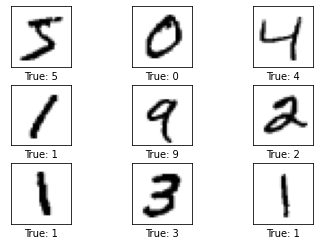

In [9]:
# plot test-set data
plot_images(X_train[:9], y_train[:9])  # 默认图片大小是(28, 28)

### 3.2 Visualizing predicted result
画出错误分类的数据

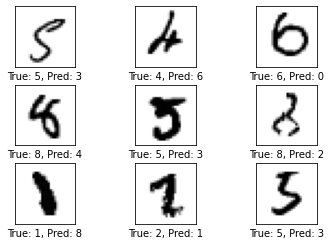

In [10]:
y_pred = model2.predict(X_test)

cls_pred = np.argmax(y_pred, axis=1)

# 下面程序用来检测出九个错误的预测，绘制其图片。
incorrect = (cls_pred != y_test)  # (array1 != array2)，不相同的元素的位置是 True
plot_images(X_test[incorrect][:9], cls_true=y_test[incorrect][:9], cls_pred=cls_pred[incorrect][:9])

### 3.3 Visualization of Layer Weights and Outputs

#### 3.3.1 Get layers

In [15]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               200832    
_________________________________________________________________
softmax (Dense)              (None, 10)                1290      
Total para

In [16]:
model2.layers  # 返回一个包含所有层的列表

In [17]:
layer_conv1 = model2.layers[0]  # 第一层
weights = layer_conv1.get_weights()
# 返回一个长度为 2 的 list，list第一个是权值的 array，第二个是偏置的 array
# weights[0]  # 权值
print('权值矩阵的shape: ', weights[0].shape,
      '\n第一个卷积模板: ', weights[0][:, :, :, 1])
# weights[1]  # 偏置
print('偏置矩阵的shape: ', weights[1].shape,
      '\n前五个偏置: ', weights[1][:5])  # 权值)


权值矩阵的shape:  (5, 5, 1, 16) 
第一个卷积模板:  [[[ 0.00508823]
  [-0.01227068]
  [ 0.10347782]
  [ 0.01024839]
  [ 0.03658053]]

 [[-0.0032999 ]
  [ 0.00186982]
  [ 0.10577655]
  [ 0.02447881]
  [-0.18575186]]

 [[ 0.03703334]
  [-0.04899551]
  [ 0.12240934]
  [-0.22484154]
  [-0.28266853]]

 [[ 0.10810184]
  [ 0.1836588 ]
  [-0.06505233]
  [-0.10601709]
  [-0.00207529]]

 [[ 0.18001153]
  [ 0.13414599]
  [ 0.14451754]
  [ 0.0876734 ]
  [-0.06398289]]]
偏置矩阵的shape:  (16,) 
前五个偏置:  [ 0.00953509 -0.01113979 -0.01340452 -0.0099901  -0.00530564]


#### 3.3.2 Convolutional Weights

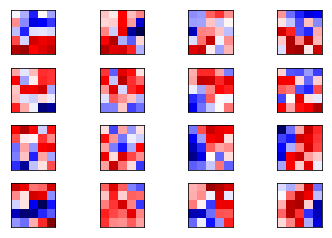

In [18]:
# 绘制第一层（第一次卷积层）的权值
layer_conv1 = model2.layers[0]  # 第一层
weights = layer_conv1.get_weights()

plot_conv_weights(weights[0])

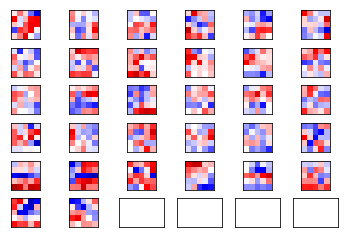

In [19]:
# 绘制第三层（第二次卷积层）的权值
layer_conv1 = model2.layers[2]  # 第一层
weights = layer_conv1.get_weights()

plot_conv_weights(weights[0])

### 3.4 Visualizing the output of ConvNet
keras 使用 Model类，来获取模型内层的输出

#### 3.4.1 可视化第一次的卷积层(conv1)输出

(1, 28, 28, 16)

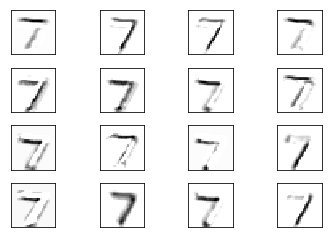

In [20]:
from tensorflow.keras.models import Model

# 可视化第一层卷积层的输出
conv1 = model2.layers[0]
output_conv1 = Model(inputs=conv1.input,
                     outputs=conv1.output
                    )
# 第一层卷积层 filter_num = 16, 输入一张图片会输出 16 张图片
feature_1 = output_conv1.predict(X_test[0].reshape(-1, 28, 28, 1))
feature_1.shape

# 调用上面函数来可视化
plot_conv_output(feature_1)

#### 3.4.2 可视化第二次的卷积层(conv2)输出

(1, 14, 14, 32)

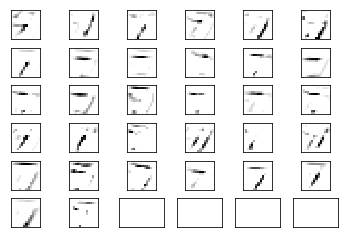

In [21]:
# 可视化第二层卷积层的输出
conv2 = model2.layers[2]
output_conv2 = Model(inputs=conv1.input,
                     outputs=conv2.output
                    )
# 第一层卷积层 filter_num = 16, 输入一张图片会输出 16 张图片
feature_2 = output_conv2.predict(X_test[0].reshape(-1, 28, 28, 1))
feature_2.shape  # (n_sample, height, width, channels)

# 调用上面函数来可视化
plot_conv_output(feature_2)

## 4. Save & Restore model
将训练的模型保存下来

### 4.1 Save

In [22]:
# file path and file name where we want to save model.
path_model = './model2-1126.keras'

# save model
model2.save(path_model)

### 4.2 Restore

In [23]:
from tensorflow.keras.models import load_model

# file path where we saved model
model3 = load_model(path_model)

# test restored model
model3.evaluate(X_test, y_test)

10000/10000 [==============================] - 11s 1ms/step


[0.03833215410306584, 0.9865]

## 5. 问题总结

### 5.1 loss function

`sparse_categorical_crossentropy` and `categorical_crossentropy`:  
1. 两个都是多分类问题的损失函数，  
2. 区别是`sparse_categorical_crossentropy` 对应的输出类别是 **integer**，使用单个整数来表示特征。  
比如上面的例子里 y_train 和 y_test 都是单个的从 0 到 9 之间的数字，那使用此 loss function 就不需要再对其进行任何操作。  
而 `categorical_crossentropy` 对应的输出类别是 **one-hot encoded**(独热编码)，离散特征有多少取值，就用多少维的向量来表示该特征。  
比如上面例子如果使用此 loss function 就需要把 y 编码成 10 维的向量。使用

```
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
```


### 5.2 关于 batch_size, steps(/iterations), epochs

`batch_size`: 在每次更新网络权值时大多数优化算法都是随机使用训练集的一部分`(MBGD)`，而每次使用训练集的多少？那就是 batch_size 来决定。上面使用 batch_size=128，就是每次使用训练集的 128 个数据来计算 loss 再更新一次权值。

`steps`: 有的地方称 iterations。每一个 `step` 都会使用 batch_size个数据来更新权值，等于训练集数量除以`batch_size`向上取整: n_sample / batch_size。上面程序中训练集是 60000张，而 batch_size=128，那网络的 steps = np.ceil(60000/128).astype(np.int64)。

`epochs`: 把整个训练集循环使用的次数。


### 5.3 NHWC 与 NCHW
`N`: number of sample, 训练样本的数量; `H`: height of image, 图片像素矩阵的高;  
`W`: width of image, 图片像素矩阵的宽; `C`: 图片的通道，灰度图通道数是一，彩色图通道数是三。

`NHWC` 与 `NCHW` 的区别就是数据的排列方式。数据的通道数在图片尺寸之前还是之后。详细查看大神所总结的[TensorFlow API 中 NCHW 与 NHWC 的区别](https://mp.weixin.qq.com/s/I4Q1Bv7yecqYXUra49o7tw?)

使用时的推荐：  
`NHWC`: 访存局部性更好，cache 利用率高。使用 **CPU** 来训练时使用。  
`NCHW`: 需要占用较大的临时空间。使用 **GPU** 来训练时使用。  